# Unbalanced Optimal Transport

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gpeyre/ot4ml/blob/main/python/5-unbalanced.ipynb)

This numerical tour details how to perform **unbalanced optimal transport (OT)**, which allows the comparison of measures with different total mass. Unbalanced OT also leads to **more regular transportation plans** by permitting the creation and destruction of mass.

This extension of classical (or "balanced") OT is crucial in many applications in **imaging sciences** and **machine learning**, where it enhances the robustness of OT to **noise**, **outliers**, and **incomplete data**.

The modification from the standard OT formulation is relatively minor: it involves adding a **penalization of the mass conservation constraint**, rather than enforcing exact marginal matching.

The foundational idea was introduced in the paper:

- [Matthias Liero, Alexander Mielke, and Giuseppe Savaré (2015)](https://arxiv.org/abs/1508.07941)

An **entropically regularized** formulation of unbalanced OT, along with a generalized Sinkhorn algorithm to solve it, can be found in:

- [Lénaïc Chizat, Gabriel Peyré, Bernhard Schmitzer, and François-Xavier Vialard (2016)](https://arxiv.org/abs/1607.05816)

Installing the JuMP and HiGHS packages for convex optimization.

In [ ]:
import Pkg
Pkg.activate(".")
Pkg.add(["Convex", "Clarabel", "StatsBase"])

  Activating new project at `/content`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed CodecBzip2 ─────────── v0.8.5
   Installed JSON3 ──────────────── v1.14.3
   Installed SnoopPrecompile ────── v1.0.3
   Installed TimerOutputs ───────── v0.5.29
   Installed BenchmarkTools ─────── v1.6.0
   Installed MutableArithmetics ─── v1.6.4
   Installed StructTypes ────────── v1.11.0
   Installed GenericLinearAlgebra ─ v0.3.17
   Installed AMD ────────────────── v0.5.3
   Installed LDLFactorizations ──── v0.10.1
   Installed QDLDL ──────────────── v0.4.1
   Installed Clarabel ───────────── v0.11.0
   Installed MathOptInterface ───── v1.42.0
   Installed Convex ─────────────── v0.16.4
    Updating `/content/Project.toml`
  [61c947e1] + Clarabel v0.11.0
  [f65535da] + Convex v0.16.4
  [2913bbd2] + StatsBase v0.34.5
    Updating `/content/Manifest.toml`
  [14f7f29c] + AMD v0.5.3
  [1520ce14] + AbstractTrees v0.4.5
  [66dad0bd] + AliasTables

In [ ]:
using Plots
using Convex
using Clarabel

In [ ]:
function imshow!(plt, data, title="")
    heatmap!(
        plt,
        data,
        aspect_ratio=:equal,
        colorbar=false,
        yflip=true,
        title=title,
        axis=false
    )
end

imshow! (generic function with 2 methods)

Definition of the input measures
------------------------------------------

For the sake of concreteness and ease of visualization, we focus on the transport between **1D distributions**. However, the same principles and algorithms apply to more general OT problems in higher dimensions or other metric spaces.

We consider two **discrete distributions**:
$$
\sum_{i=1}^n a_i \, \delta_{x_i} \quad \text{and} \quad
\sum_{j=1}^m b_j \, \delta_{y_j},
$$
where:
- $n$ and $m$ are the number of Dirac masses in each distribution,
- $\delta_x$ denotes the Dirac mass located at $x$,
- $(x_i)_i$ and $(y_j)_j$ are the positions of the Dirac masses in some metric space (here, we consider $\mathbb{R}$),
- $a_i$, $b_j$ are non-negative weights summing to 1.

This setup provides a simple and interpretable framework to experiment with **unbalanced OT** methods.

In [ ]:
n = 120
m = 110;

We consider two Gaussian measures sampled on a 1-D grid.

In [ ]:
Gaussian(t0, sigma, N) = exp.(-((0:N-1)/N .- t0).^2 ./ (2*sigma^2))
normalize(p) = p ./ sum(p)
sigma = .06;
a = Gaussian(.25, sigma, n)
b = Gaussian(.8, sigma, m);

Add some minimal mass and normalize. Here we do not use the same total mass for $a$ and $b$.

In [ ]:
vmin = .01
a = 0.95 .* normalize(a .+ maximum(a)*vmin)
b = 1.05 .* normalize(b .+ maximum(b)*vmin)
x = (0:n-1) ./ n
y = (0:m-1) ./ m;

Display the histograms.

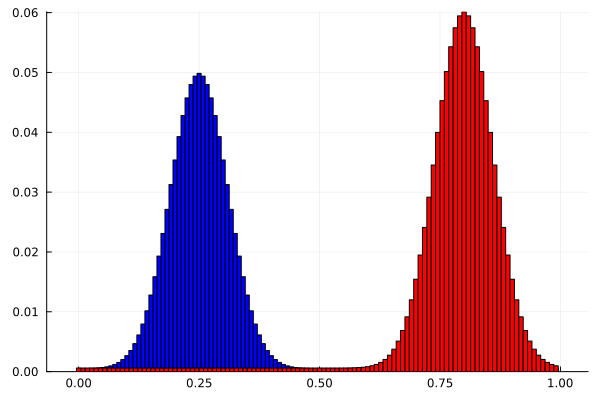

In [ ]:
plot(x, a, seriestype=:bar, label=nothing, bar_width = 1/n, color = :blue)
plot!(y, b, seriestype=:bar, label=nothing, bar_width = 1/m, color = :red)

We now compute the **cost matrix** $C$, which encodes the pairwise transport costs between the source and target points.

In this case, we use the **squared Euclidean distance** on the real line:
$$
C_{i,j} = \|x_i - y_j\|^2,
$$
where:
- $x_i$ and $y_j$ are the positions of the source and target Dirac masses,
- $\|\cdot\|$ is the standard Euclidean norm on $\mathbb{R}$.

This cost matrix will be used in the computation of the unbalanced optimal transport plan.

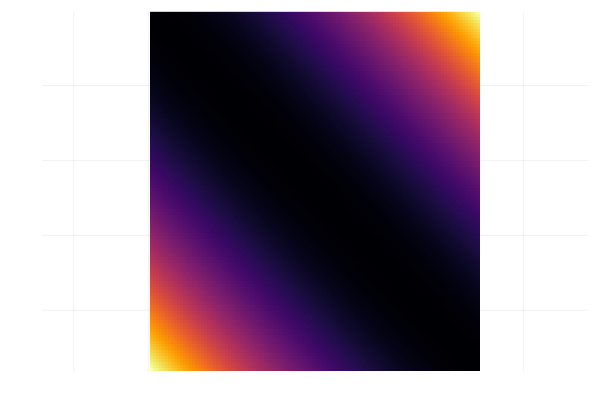

In [ ]:
C = (x .- y').^2
imshow!(plot(), C)

Kantorovitch-Hellinger / Wasserstein-Fisher-Rao Transport
------------------------------------------

We now define the **unbalanced optimal transport (OT)** problem. Unlike classical OT, unbalanced OT allows for differences in total mass between the source and target distributions, enabling mass creation and destruction.

The unbalanced OT problem is formulated as:
$$
W_\rho(a, b) \triangleq \min_{P \in \mathbb{R}_+^{n \times m}} \langle P, C \rangle
+ \rho \, D_\phi(P \mathbf{1}_m \,|\, a)
+ \rho \, D_\phi(P^\top \mathbf{1}_n \,|\, b),
$$
where:
- $P$ is the transport matrix,
- $C$ is the cost matrix (e.g., squared Euclidean distances),
- $\mathbf{1}_n$ is the vector of ones,
- $D_\phi$ is a so-called [Csiszár f-divergence](https://en.wikipedia.org/wiki/F-divergence), defined as:
$$
D_\phi(h \,|\, b) \triangleq \sum_i \phi\left(\frac{h_i}{b_i}\right) b_i.
$$

Two commonly used divergences are:
- The **Kullback-Leibler (KL) divergence**: $\phi(s) = s \log s - s + 1$
- The **Total Variation (TV)** distance: $\phi(s) = |s - 1|$

These are the two divergences we will explore in this notebook.

The parameter $\rho > 0$ controls the **relaxation of mass conservation**:
- As $\rho \to +\infty$, the problem approaches the classical (balanced) OT.
- As $\rho \to 0$, the transport cost dominates and **no transport is performed**—mass is entirely created or destroyed at will.

This framework makes OT **robust to noise, outliers, and unmatched mass**, which is essential for real-world data applications.

Define the optimization variable $P$, the OT coupling.

In [ ]:
P = Variable(n, m);

We first consider the case of $\phi(s) = s \log(s) - s + 1$, which corresponds to the **Kullback-Leibler (KL) divergence**. In this setting, the unbalanced OT problem is often referred to as:

- **Kantorovich-Hellinger distance**, or
- **Wasserstein-Fisher-Rao (WFR)** distance.

This formulation is particularly well-suited for applications where both **transport** and **density modulation** (e.g., mass variation) are important.

Assuming $n = m$ and that the sampling locations are aligned ($x_i = y_i$), the normalized unbalanced transport cost behaves like the **squared Hellinger distance** in the limit $\rho \to +\infty$:
$$
\frac{W_\rho(a, b)}{\rho} \longrightarrow \sum_{i} \left(\sqrt{a_i} - \sqrt{b_i}\right)^2.
$$

This provides a useful connection between optimal transport and classical divergences in probability theory.

We define the Convex.jl problem and solve it.

In [ ]:
u = ones(n, 1)
v = ones(m, 1)

# Express KL divergence in terms of relative entropy
kl_div(h, b) = sum(Convex.relative_entropy(h, b)) - sum(h) + sum(b)

q = kl_div(P * v, a)
r = kl_div(P' * u, b)

constraints = [P >= 0]
# Uncomment below for balanced OT
#constraints = [P >= 0, P * v == a, P' * u == b]

rho = 0.1
objective = sum(P .* C) + rho * q + rho * r

problem = minimize(objective, constraints)
solve!(problem, Clarabel.Optimizer, silent=true);

Display the solution coupling.

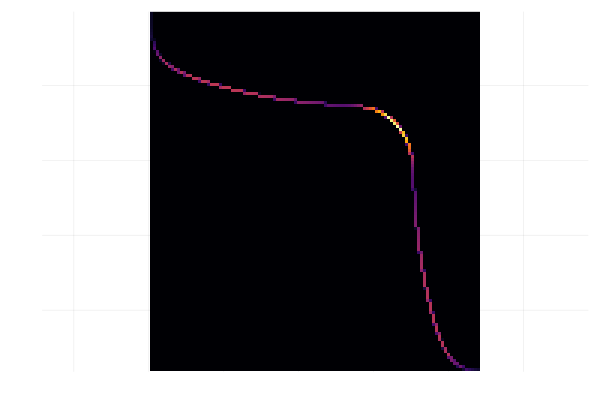

In [ ]:
remap_plan(P) = log.(0.001 .+ P)
imshow!(plot(), remap_plan(P.value))

Display the marginals.

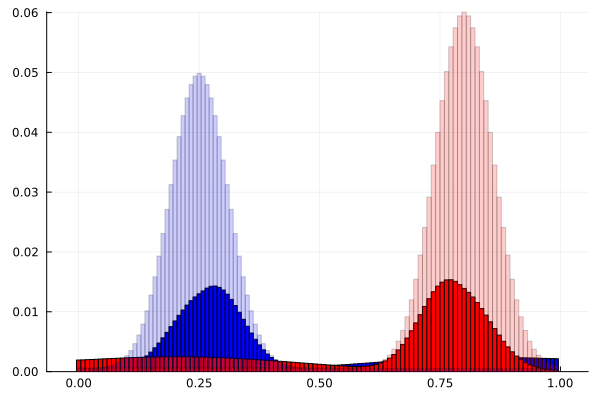

In [ ]:
a1 = sum(P.value, dims=2)
b1 = sum(P.value, dims=1)'
plot(legend=false)
plot!(x, a1, seriestype=:bar, bar_width=1/n, color=:blue)
plot!(y, b1, seriestype=:bar, bar_width=1/m, color=:red)
plot!(x, a, seriestype=:bar, bar_width=1/n, color=:blue, alpha=0.2)
plot!(y, b, seriestype=:bar, bar_width=1/m, color=:red, alpha=0.2)

Shows the impact of $\rho$ on the solution.

In [ ]:
function set_P_q_r_kl()
    P = Variable(n, m)
    q = kl_div(P * v, a)
    r = kl_div(P' * u, b)
    return P, q, r
end

set_P_q_r_kl (generic function with 1 method)

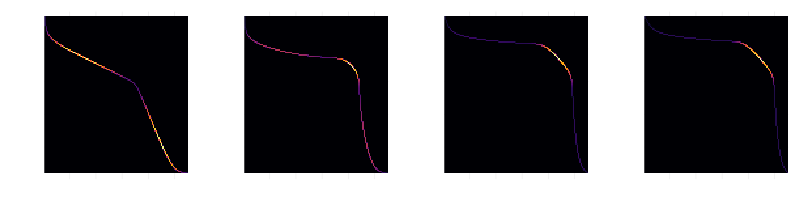

In [ ]:
rho_list = [.03, .1, .5, 1]
nb_rho = length(rho_list)
plt = plot(layout=(1, nb_rho), size=(200*nb_rho, 200))
for (k, rho) in enumerate(rho_list)
    P, q, r = set_P_q_r_kl()
    constraints = [P >= 0]
    objective = sum(P .* C) + rho * q + rho * r
    problem = minimize(objective, constraints)
    solve!(problem, Clarabel.Optimizer, silent=true)
    imshow!(plt[k], remap_plan(P.value))
end
display(plt)

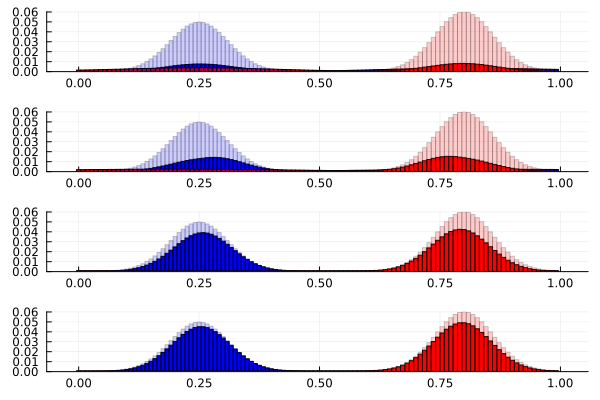

In [ ]:
plt = plot(layout=(nb_rho,1), size=(600, 100*nb_rho), legend=false)
for (k, rho) in enumerate(rho_list)
    P, q, r = set_P_q_r_kl()
    constraints = [P >= 0]
    objective = sum(P .* C) + rho * q + rho * r
    problem = minimize(objective, constraints)
    solve!(problem, Clarabel.Optimizer, silent=true)
    a1 = sum(P.value, dims=2)
    b1 = sum(P.value, dims=1)'
    plot!(plt[k], x, a1, seriestype=:bar, bar_width=1/n, color=:blue)
    plot!(plt[k], y, b1, seriestype=:bar, bar_width=1/m, color=:red)
    plot!(plt[k], x, a, seriestype=:bar, bar_width=1/n, color=:blue, alpha=0.2)
    plot!(plt[k], y, b, seriestype=:bar, bar_width=1/m, color=:red, alpha=0.2)
end
display(plt)

Partial Optimal Transport
=========

We can also consider other divergences within the unbalanced OT framework. A notable example is the **total variation (TV)** divergence, defined using:
$$
\phi(s) = |s - 1|.
$$

This leads to the divergence:
$$
D_\phi(h \,|\, a) = \|a - h\|_1 = \sum_i |a_i - h_i|,
$$
which corresponds to the **$\ell^1$ norm** between the original and transported marginals.

The resulting OT problem is known as a **penalized partial transport** problem. Unlike the KL-based formulation (e.g., Wasserstein-Fisher-Rao), which softly relaxes mass conservation, the total variation version has a much sharper behavior:

- It **either transports mass or destroys it** entirely.
- There is no smooth interpolation between moving and erasing mass.

This makes the TV-based unbalanced OT particularly well-suited for problems where **strict selection of transportable mass** is desired, such as in segmentation or matching under strict budget constraints.

In [ ]:
function set_P_q_r_TV()
    P = Variable(n, m)
    q = Convex.norm(P * v - a, 1)
    r = Convex.norm(P' * u - b, 1)
    return P, q, r
end
P, q, r = set_P_q_r_TV();

We now display the **marginals of the optimal transport plan** $P$:

- The **row sum** $P \mathbf{1}_m$ approximates the transported source marginal,
- The **column sum** $P^\top \mathbf{1}_n$ approximates the transported target marginal.

To better visualize the quality of the approximation, we display the original densities $a$ and $b$ alongside their transported counterparts.

You may notice the presence of **small oscillatory spikes** in the transported marginals. These are artifacts caused by the **discretization** of the problem. To help assess the impact of these artifacts, we display the two transported marginals **stacked vertically and flipped** (i.e., one mirrored upside-down).

This visualization reveals that many of the local deviations between the original and transported marginals **cancel each other out**, which suggests that these discrepancies are largely numerical rather than structural.

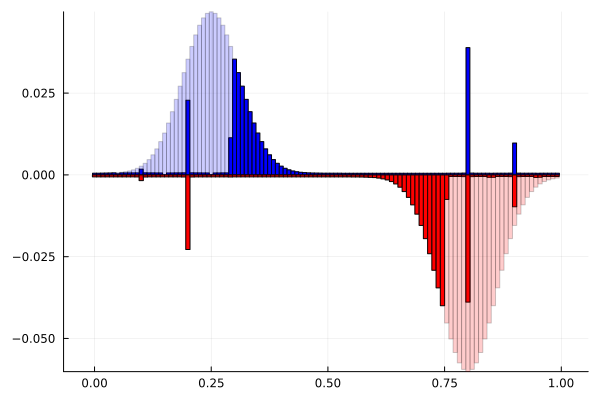

In [ ]:
rho =0.1
constraints = [P >= 0]
objective = sum(P .* C) + rho * q + rho * r
problem = minimize(objective, constraints)
solve!(problem, Clarabel.Optimizer, silent=true)
a1 = sum(P.value, dims=2)
b1 = sum(P.value, dims=1)'
plot(x, a1, seriestype=:bar, bar_width=1/n, color=:blue, legend=false)
plot!(y, -b1, seriestype=:bar, bar_width=1/m, color=:red)
plot!(x, a, seriestype=:bar, bar_width=1/n, color=:blue, alpha=0.2)
plot!(y, -b, seriestype=:bar, bar_width=1/m, color=:red, alpha=0.2)

Display the impact of $\rho$.

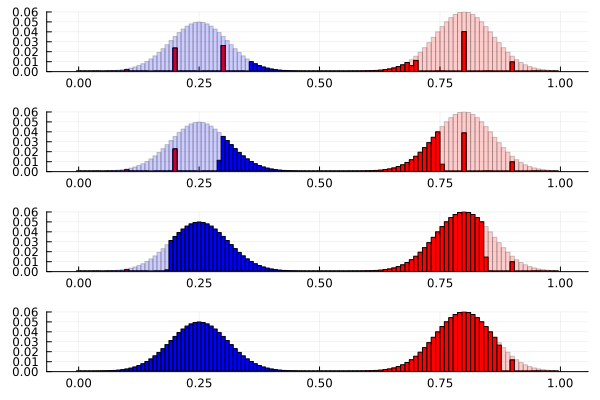

In [ ]:
rho_list = [.05, .1, .2, 5]
nb_rho = length(rho_list)
plt = plot(layout=(nb_rho,1), size=(600, 100*nb_rho), legend=false)
for (k, rho) in enumerate(rho_list)
    P, q, r = set_P_q_r_TV()
    constraints = [P >= 0]
    objective = sum(P .* C) + rho * q + rho * r
    problem = minimize(objective, constraints)
    solve!(problem, Clarabel.Optimizer, silent=true)
    a1 = sum(P.value, dims=2)
    b1 = sum(P.value, dims=1)'
    plot!(plt[k], x, a1, seriestype=:bar, bar_width=1/n, color=:blue)
    plot!(plt[k], y, b1, seriestype=:bar, bar_width=1/m, color=:red)
    plot!(plt[k], x, a, seriestype=:bar, bar_width=1/n, color=:blue, alpha=0.2)
    plot!(plt[k], y, b, seriestype=:bar, bar_width=1/m, color=:red, alpha=0.2)
end
display(plt)

We can compare several $\phi$-divergence.

Entropic Regularization and Sinkhorn
=========

To improve numerical stability and enable faster computations, it is possible to **regularize** the unbalanced OT problem using **entropic regularization**. This leads to the following formulation:
$$
\min_{P \in \mathbb{R}_+^{n \times m}} \langle P, C \rangle
+ \rho \, \mathrm{KL}(P \mathbf{1}_m \,|\, a)
+ \rho \, \mathrm{KL}(P^\top \mathbf{1}_n \,|\, b)
+ \varepsilon \, \mathrm{KL}(P \,|\, a b^\top),
$$
where:
- $\rho > 0$ controls the relaxation of mass conservation (as in unbalanced OT),
- $\varepsilon > 0$ controls the strength of the **entropic regularization**.

This additional term $\varepsilon \, \mathrm{KL}(P \,|\, a b^\top)$ is the **entropic regularization term**. It is the Kullback-Leibler (KL) divergence between the transport plan $P$ and the outer product of the marginals $a b^\top$.

The solution $P$ of the entropically regularized unbalanced OT problem can be shown to take the form:
$$
P_{i,j} = \exp\left( \frac{f_i + g_j - C_{i,j}}{\varepsilon} \right) a_i b_j,
$$
where:
- $f \in \mathbb{R}^n$ and $g \in \mathbb{R}^m$ are dual potentials (also known as **scaling variables in the log domain**),
- $C_{i,j}$ is the cost matrix,
- $\varepsilon > 0$ is the entropic regularization strength.


The dual potentials are computed via **generalized Sinkhorn iterations**, written here in the log domain for numerical stability:
$$
f_i = -\varepsilon \kappa \log \left( \sum_{j} \exp\left( \frac{g_j - C_{i,j}}{\varepsilon} \right) b_j \right),
$$
$$
g_j = -\varepsilon \kappa \log \left( \sum_{i} \exp\left( \frac{f_i - C_{i,j}}{\varepsilon} \right) a_i \right),
$$
where we define the constant:
$$
\kappa \triangleq \frac{\rho}{\varepsilon + \rho}.
$$

These equations are derived from the optimality conditions of the regularized problem, and **Sinkhorn's algorithm** simply alternates between these two updates until convergence.

This algorithm benefits from:
- Efficient implementation using matrix operations,
- Numerical stability from working in the log domain,
- Fast convergence when $\varepsilon$ is not too small.

We define the log-sum-exp operator (which corresponds to soft $C$-transforms).

In [ ]:
mina_u(H, epsilon) = -epsilon .* log.( sum( a .* exp.(-H ./ epsilon), dims=1))
minb_u(H, epsilon) = -epsilon .* log.( sum( b' .* exp.(-H ./ epsilon), dims=2));

 They can be stabilized using the usual [log-sum-exp trick](https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations).

In [ ]:
mina(H, epsilon) = mina_u(H .- minimum(H, dims=1), epsilon) .+ minimum(H, dims=1)
minb(H, epsilon) = minb_u(H .- minimum(H, dims=2), epsilon) .+ minimum(H, dims=2);

Values of $\varepsilon, \rho$ and $\kappa$.

In [ ]:
epsilon = .001
rho = .2
kappa = rho/(rho+epsilon);

Implement Sinkhorn's iterates.

In [ ]:
f = zeros(n)
g = zeros(n)
niter = 1000
for _ in 1:niter
    g = kappa .* mina(C .- f, epsilon)
    f = kappa .* minb(C .- g, epsilon)
end
# generate the coupling
P = a .* exp.((f .+ g .- C) ./ epsilon) .* b';

Display the optimal plan.

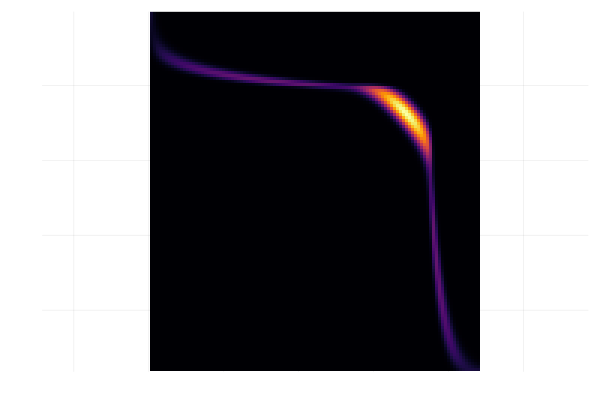

In [ ]:
imshow!(plot(), remap_plan(P))

Display the marginals.

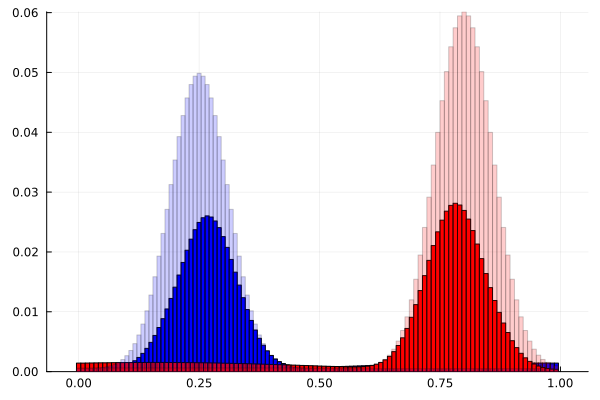

In [ ]:
a1 = sum(P, dims=2)
b1 = sum(P, dims=1)'
plot(legend=false)
plot!(x, a1, seriestype=:bar, bar_width=1/n, color=:blue)
plot!(y, b1, seriestype=:bar, bar_width=1/m, color=:red)
plot!(x, a, seriestype=:bar, bar_width=1/n, color=:blue, alpha=0.2)
plot!(y, b, seriestype=:bar, bar_width=1/m, color=:red, alpha=0.2)

#### Experiments with different values of ε and ρ

**Exercise (easy):** Experiments with different values of $\varepsilon$ and $\rho$. Study the rate of convergence of the method.

**Exercise (hard):** Extend Sinkhorn for other type of divergence, starting with TV.